In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
2022-01-25 12:16:05.837477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-25 12:16:05.837541: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.5.3 pandas==1.3.4 scikit-learn==1.0.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


In [117]:
# Enrichr setup
import json
import requests

def enrichr(genes, library='KEGG_2019_Human'):
    ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(list(genes))
    # name of analysis or list
    description = 'enrichment'
    
    ##run enrichment
    payload = {'list': (None, genes_str), 'description': (None, description)}
    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    job_id = json.loads(response.text)

    ## get enrichment results
    ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    response = requests.get(
        ENRICHR_URL + query_string % (str(job_id['userListId']), library)
     )
    if not response.ok:
        raise Exception('Error fetching enrichment results')
    print('Enrichr API : Get enrichment results: Job Id:', job_id)
    
    # construct readable dataframe
    out = pd.DataFrame(list(json.loads(response.text).values())[0])
    out.columns = [
        'Rank',
        'Term name',
        'P-value',
        'Z-score',
        'Combined score',
        'Overlapping genes',
        'Adjusted p-value',
        'Old p-value',
        'Old adjusted p-value'
    ]
    return out

In [33]:
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211015_annot_patient_integrated.h5ad')
adata = adata[adata.obs.treatment != 'nan']
adata

View of AnnData object with n_obs × n_vars = 221974 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', 'celltype_fine'
    var: 'used_for_scvi'
    uns: '_scvi', 'celltype_fine_colors', 'hvg', 'infected_colors', 'leiden', 'neighbors', 'patient_colors', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

TODO: Use scanorama to batch correct the values first so this method actually works.

Train a classifier on infection vs. non-infection in the mock sample.

In [5]:
from sklearn.linear_model import LogisticRegression

In [10]:
%%time
clf = LogisticRegression(solver='saga')
clf.fit(
    adata[adata.obs['treatment'] == 'mock'].X.toarray(),
    adata[adata.obs['treatment'] == 'mock'].obs['infected'].values
)

CPU times: user 8min 23s, sys: 10.9 s, total: 8min 34s
Wall time: 8min 35s


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(solver='saga')

In [12]:
# performance on training
clf.score(
    adata[adata.obs['treatment'] == 'mock'].X.toarray(),
    adata[adata.obs['treatment'] == 'mock'].obs['infected'].values
)

0.8474017662869576

Intepret weights.

Text(0.5, 1.0, 'logistic regression weights per gene')

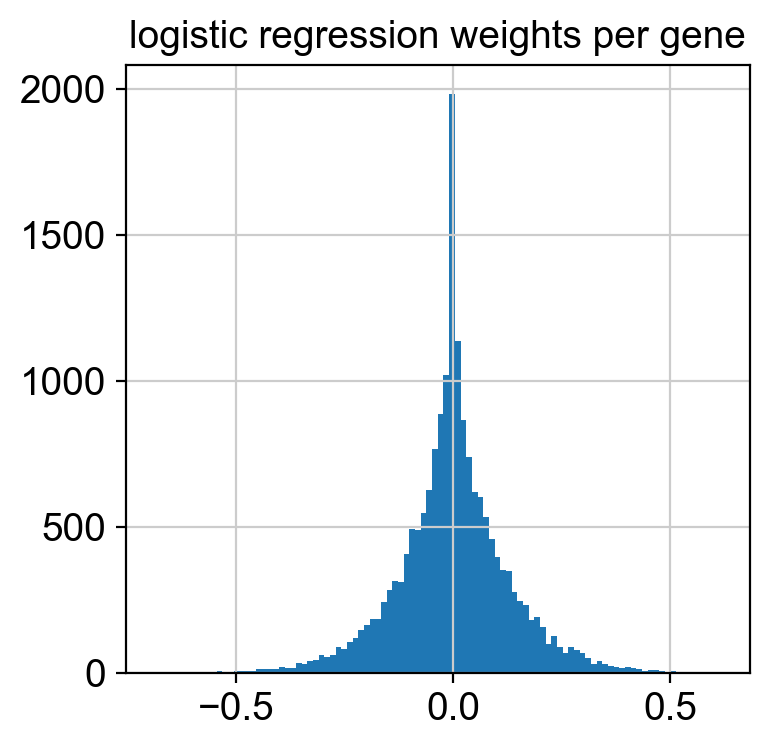

In [139]:
adata.var['logreg_coef'] = clf.coef_[0]
plt.hist(clf.coef_[0], bins=100)
plt.title('logistic regression weights per gene')

In [145]:
neg = adata.var_names[adata.var['logreg_coef'] < -.4]
pos = adata.var_names[adata.var['logreg_coef'] > .4]
enrichr(list(neg) + list(pos)).head(10)

Enrichr API : Get enrichment results: Job Id: {'shortId': '674de680c3e02c1c0aedc574d3308f33', 'userListId': 44173142}


Rank                         Term name   P-value    Z-score  \
0     1    Primary bile acid biosynthesis  0.009497  15.267823   
1     2  Herpes simplex virus 1 infection  0.011555   2.432164   
2     3    Glycosphingolipid biosynthesis  0.058988   5.318457   
3     4    Glycosaminoglycan biosynthesis  0.078514   4.482376   
4     5    Cell adhesion molecules (CAMs)  0.134410   2.417663   
5     6     Inositol phosphate metabolism  0.137019   3.171644   
6     7               Nitrogen metabolism  0.138831   7.115302   
7     8              Steroid biosynthesis  0.153848   6.324074   
8     9     Glycosaminoglycan degradation  0.153848   6.324074   
9    10         One carbon pool by folate  0.161259   5.990926   

   Combined score                                  Overlapping genes  \
0       71.098861                                    [HSD3B7, CH25H]   
1       10.848940  [ZNF484, ZNF282, ZNF836, ZNF528, ZSCAN32, ZNF8...   
2       15.053487                                 [ST3GAL6, B3GALT5]   
3       11.405322                                   [CHST15, HS6ST2]   
4        4.851919                               [VCAN, NFASC, HLA-G]   
5        6.304076                                    [ITPKB, INPP4A]   
6       14.049161                                             [CA5B]   
7       11.837325                                          [CYP51A1]   
8       11.837325                                            [HYAL3]   
9       10.931895                                          [MTHFD1L]   

   Adjusted p-value  Old p-value  Old adjusted p-value  
0          0.600875            0                     0  
1          0.600875            0                     0  
2          0.888459            0                     0  
3          0.888459            0                     0  
4          0.888459            0                     0  
5          0.888459            0                     0  
6          0.888459            0                     0  
7          0.888459            0                     0  
8          0.888459            0                     0  
9          0.888459            0                     0

Use these weights to score conditions.

In [34]:
# performance on drug: should be low for drugs that did more
scores = {}
for t in adata.obs.treatment.unique():
    scores[t] = .5 - clf.score(
        adata[adata.obs['treatment'] == t].X.toarray(),
        adata[adata.obs['treatment'] == t].obs['infected'].values
    )

(-0.1, 0.1)

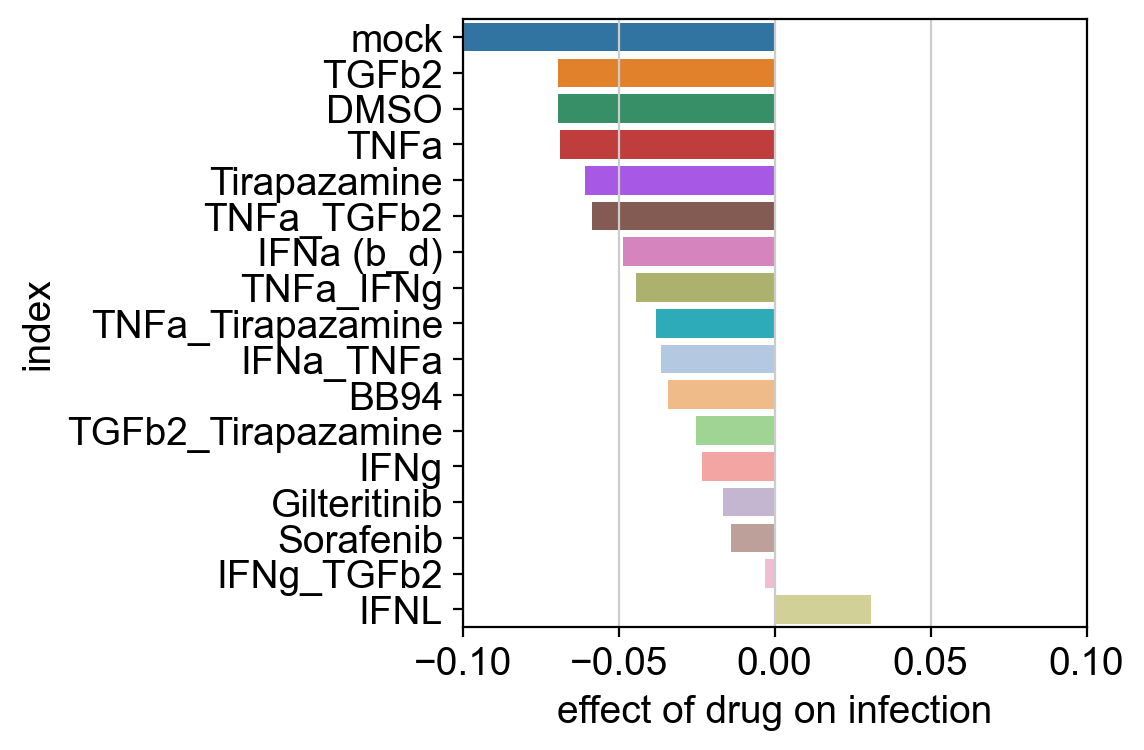

In [38]:
sns.barplot(
    data=pd.DataFrame.from_dict(scores, orient='index').reset_index().sort_values(by=0),
    x=0,
    y='index'
)
plt.xlabel('effect of drug on infection')
plt.xlim(-.1, .1)

Check: does this match the average differences in viral load between treatment and control for these samples? Yes!

In [73]:
%%time
pred = clf.predict_proba(adata.X.toarray())

CPU times: user 13.9 s, sys: 9.63 s, total: 23.5 s
Wall time: 15.3 s


In [86]:
adata.obs['probability_False'] = pred[:, 0]
adata.obs['probability_True'] = pred[:, 1]

Trying to set attribute `.obs` of view, copying.


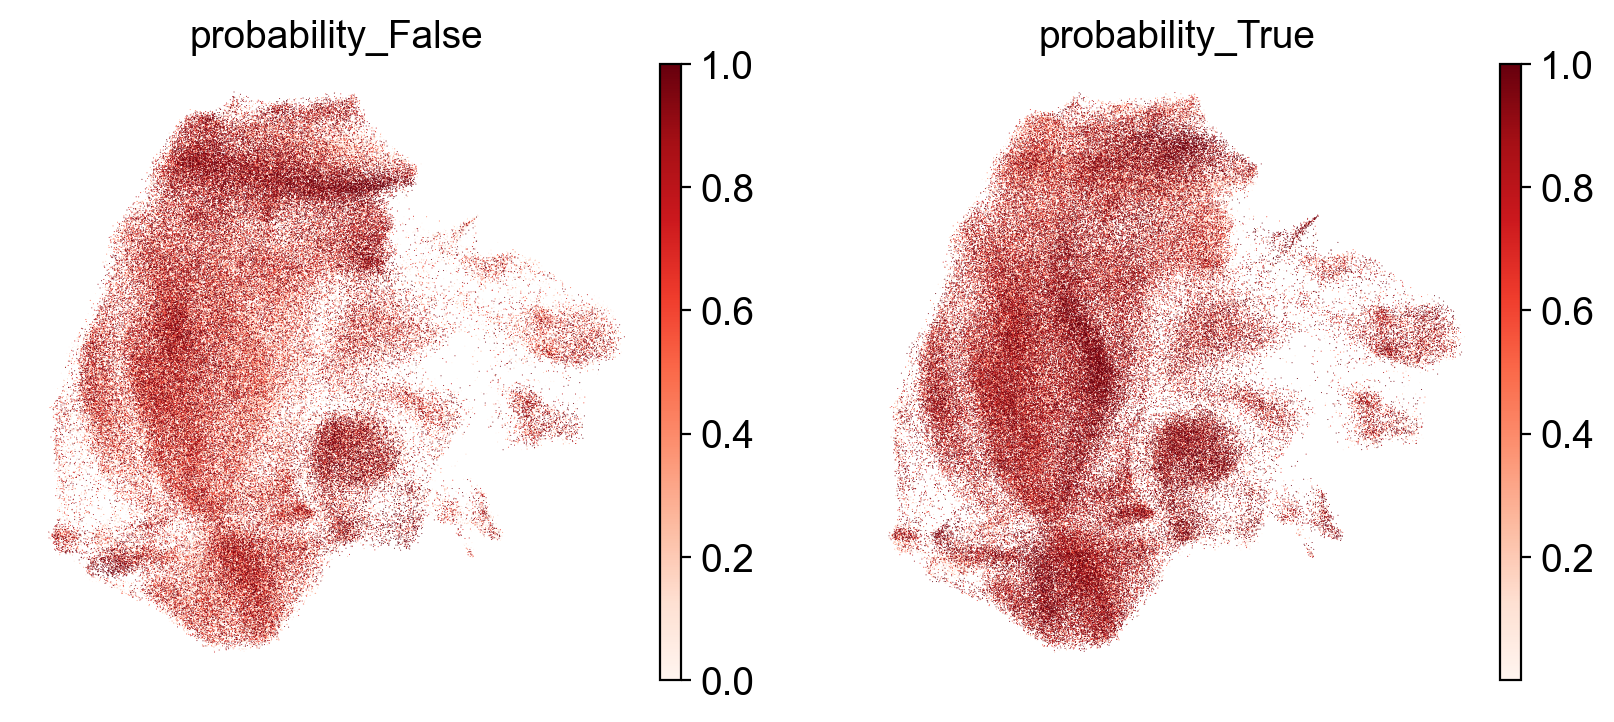

In [87]:
sc.pl.umap(adata, color=['probability_False', 'probability_True'])

In [70]:
df = adata.obs.copy()

<AxesSubplot:xlabel='probability_False', ylabel='treatment'>

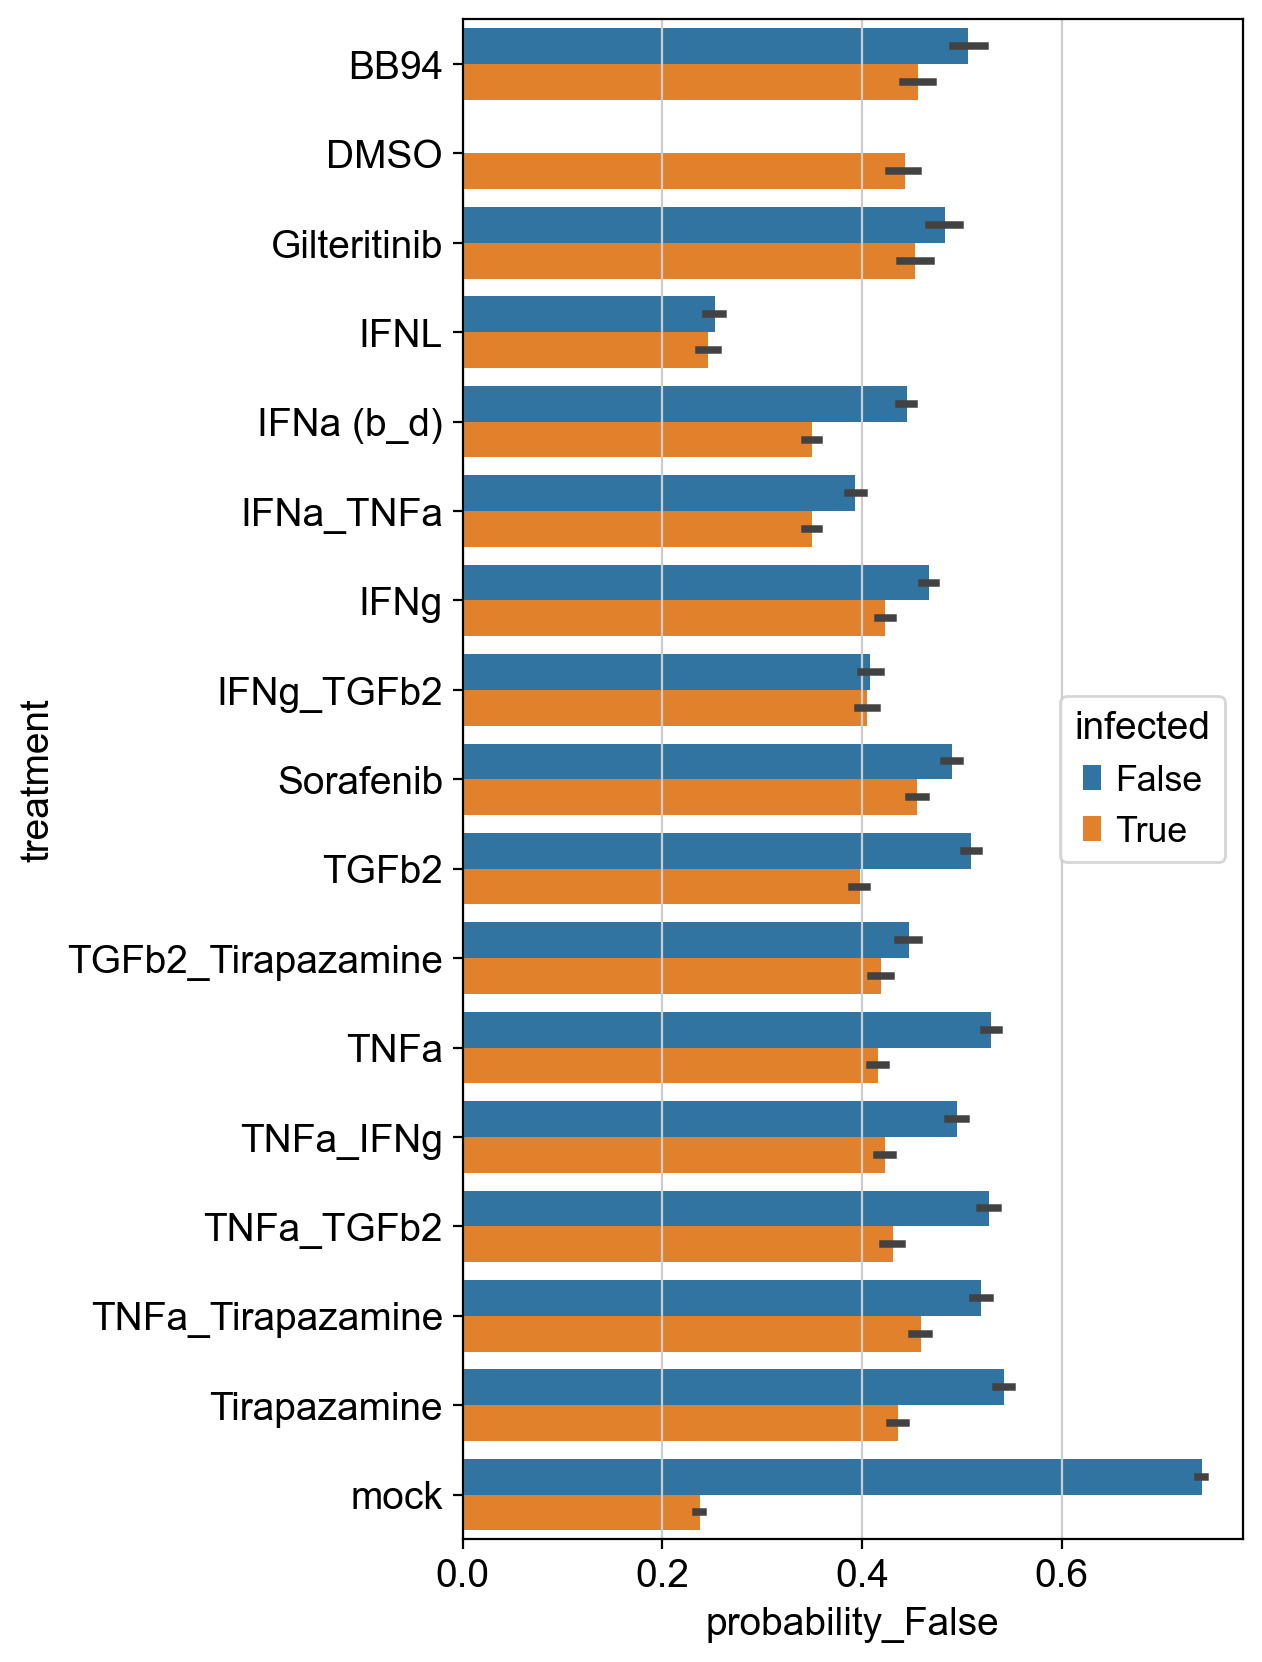

In [85]:
plt.figure(figsize=(5, 10))
sns.barplot(data=df, x='probability_False', y='treatment', hue='infected')

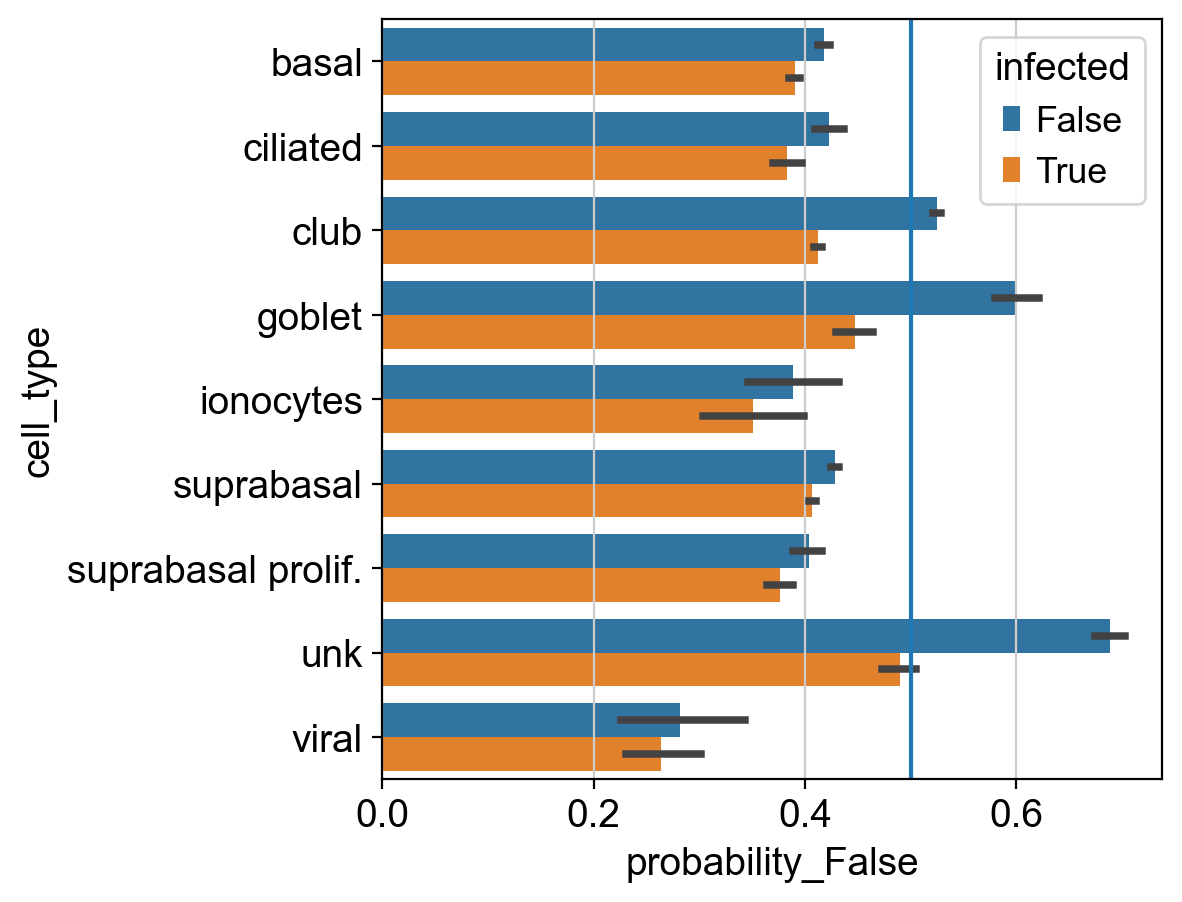

In [101]:
plt.figure(figsize=(5, 5))
sns.barplot(data=df[df.treatment != 'mock'], x='probability_False', y='cell_type', hue='infected')
plt.axvline(.5)

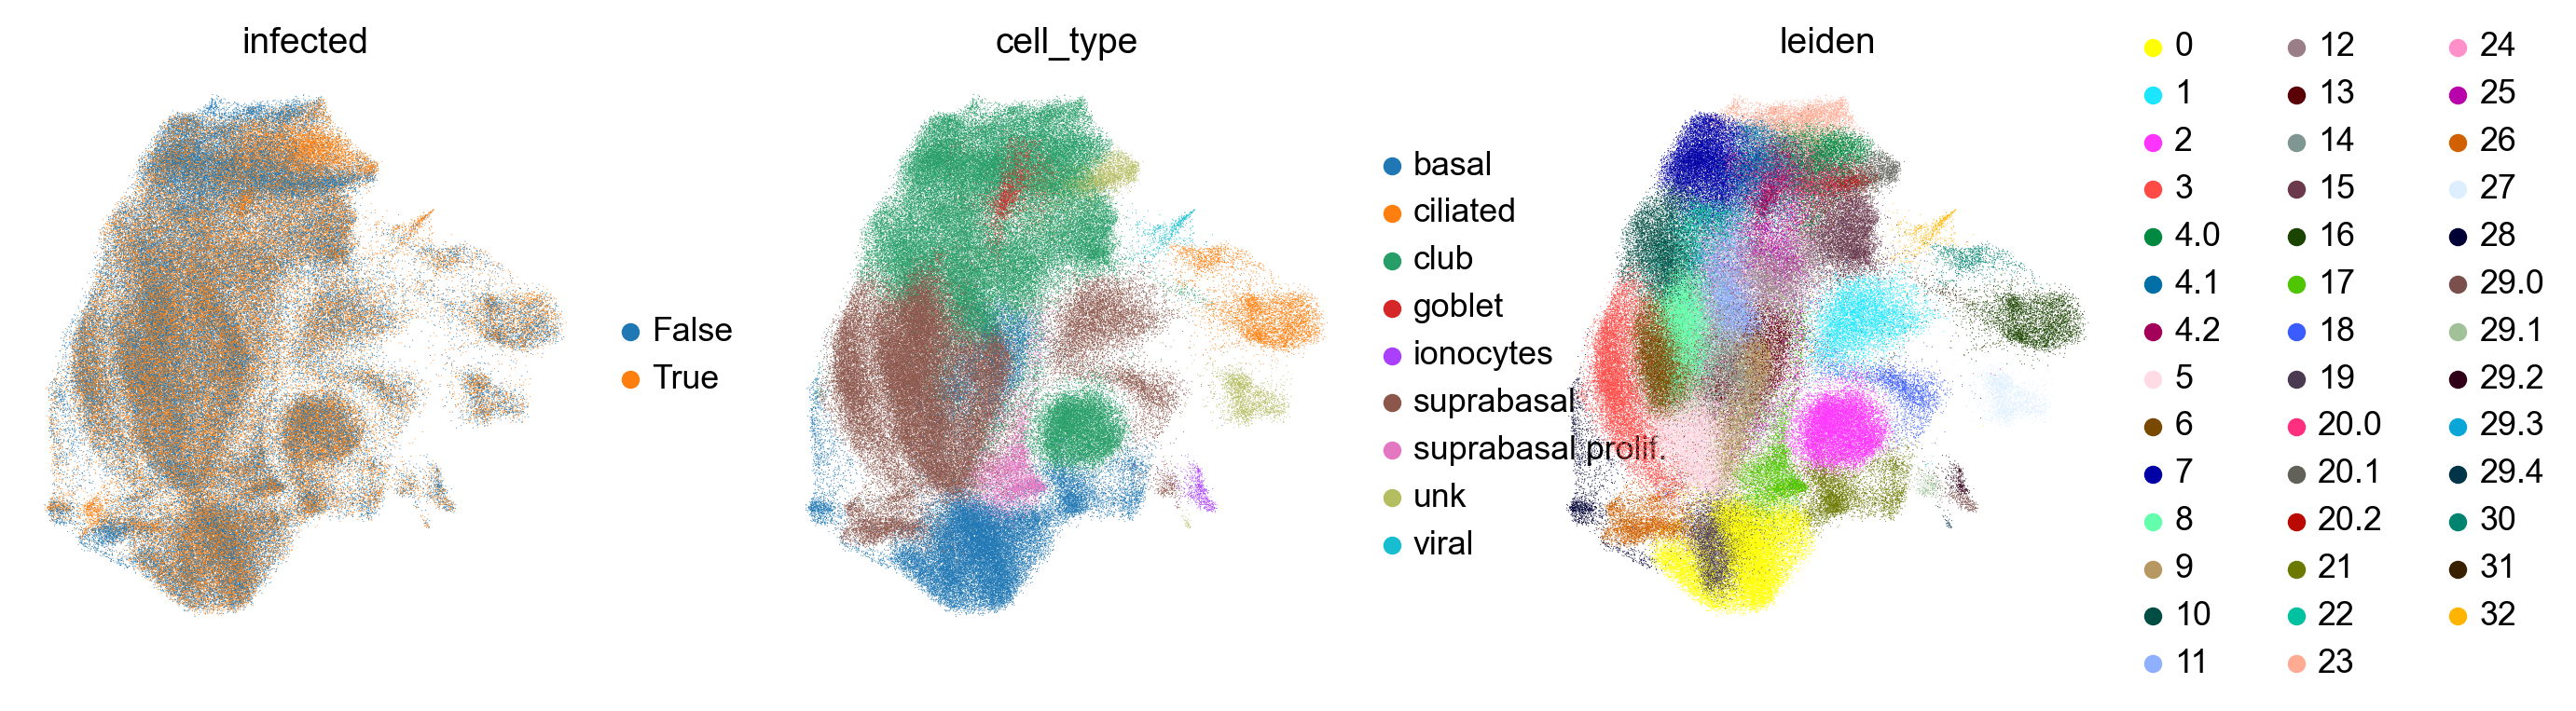

In [105]:
sc.pl.umap(adata, color=['infected', 'cell_type', 'leiden'])

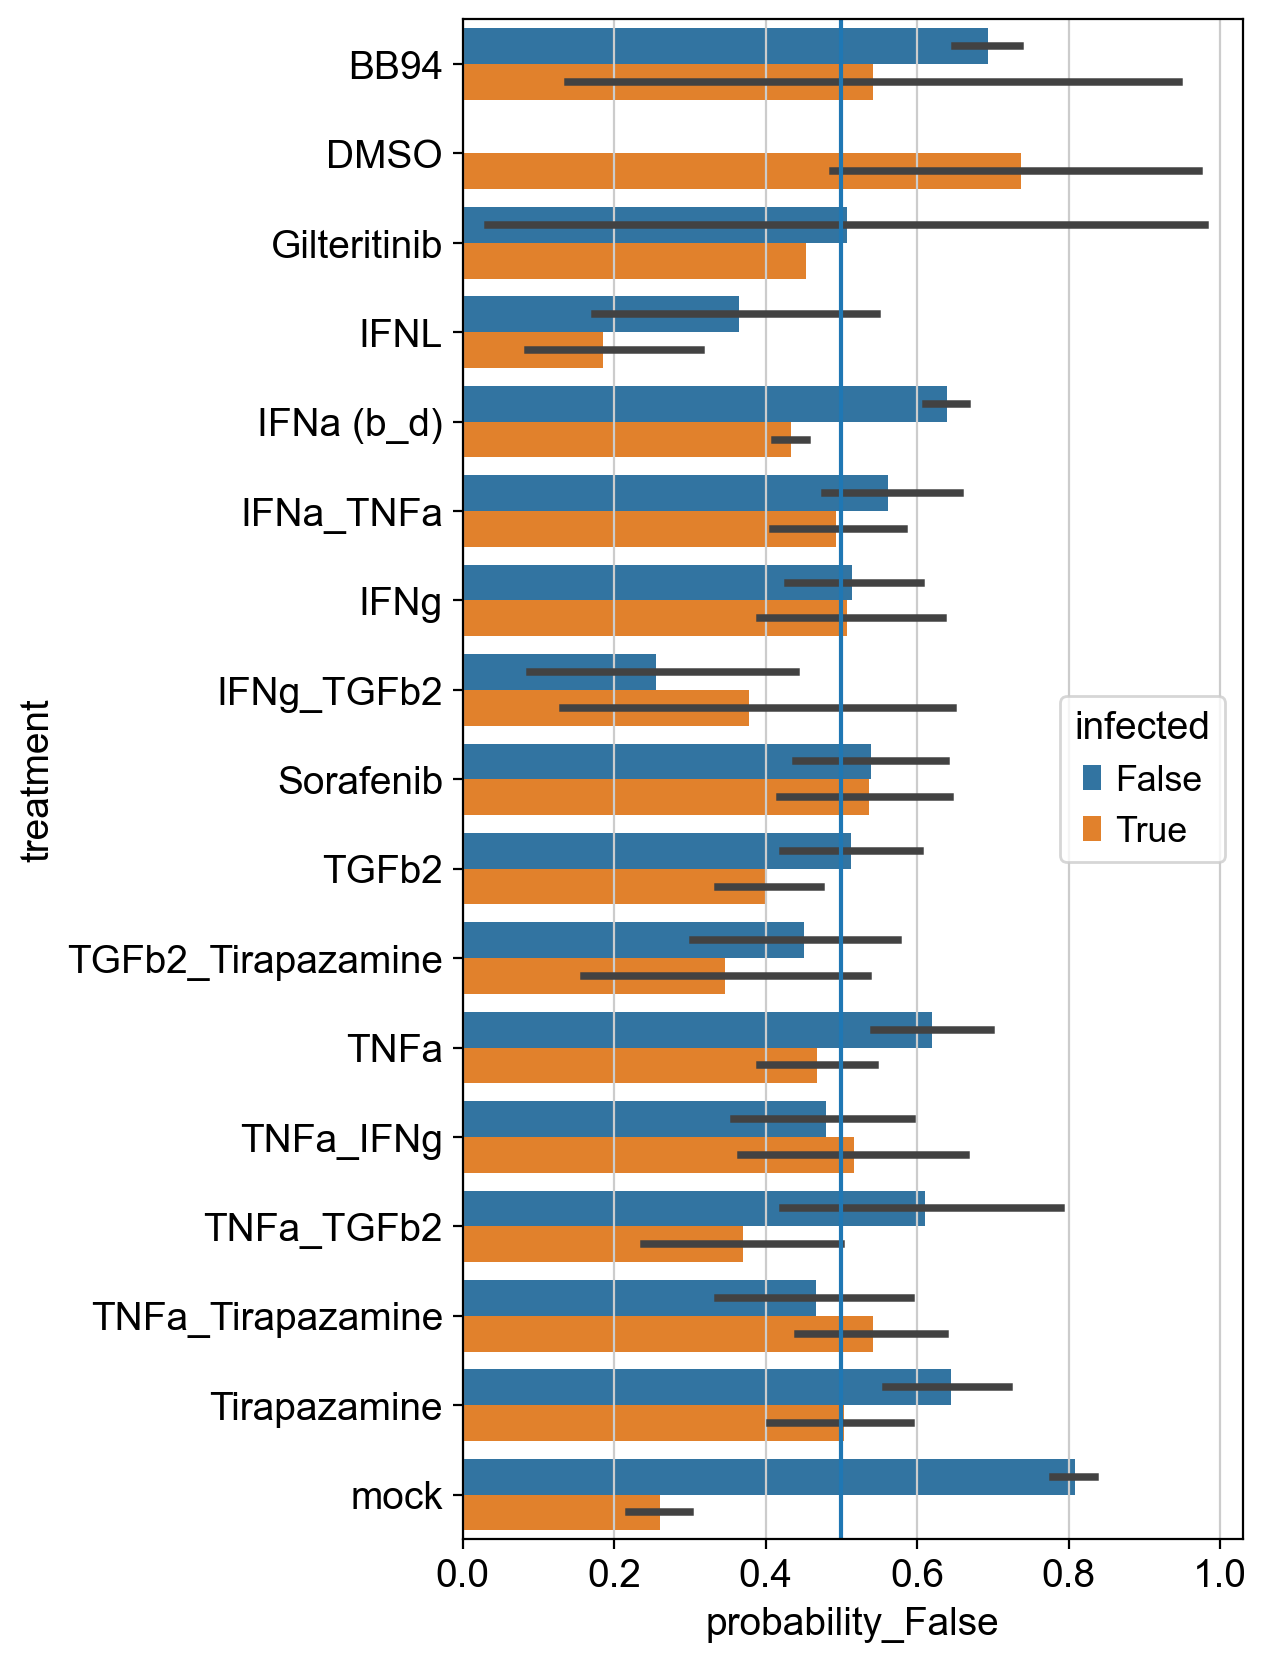

In [108]:
# among goblet cells, IFNa had the most distinct effect in infected vs. uninfected cells
plt.figure(figsize=(5, 10))
sns.barplot(data=df[df.cell_type == 'goblet'], x='probability_False', y='treatment', hue='infected')
plt.axvline(.5)

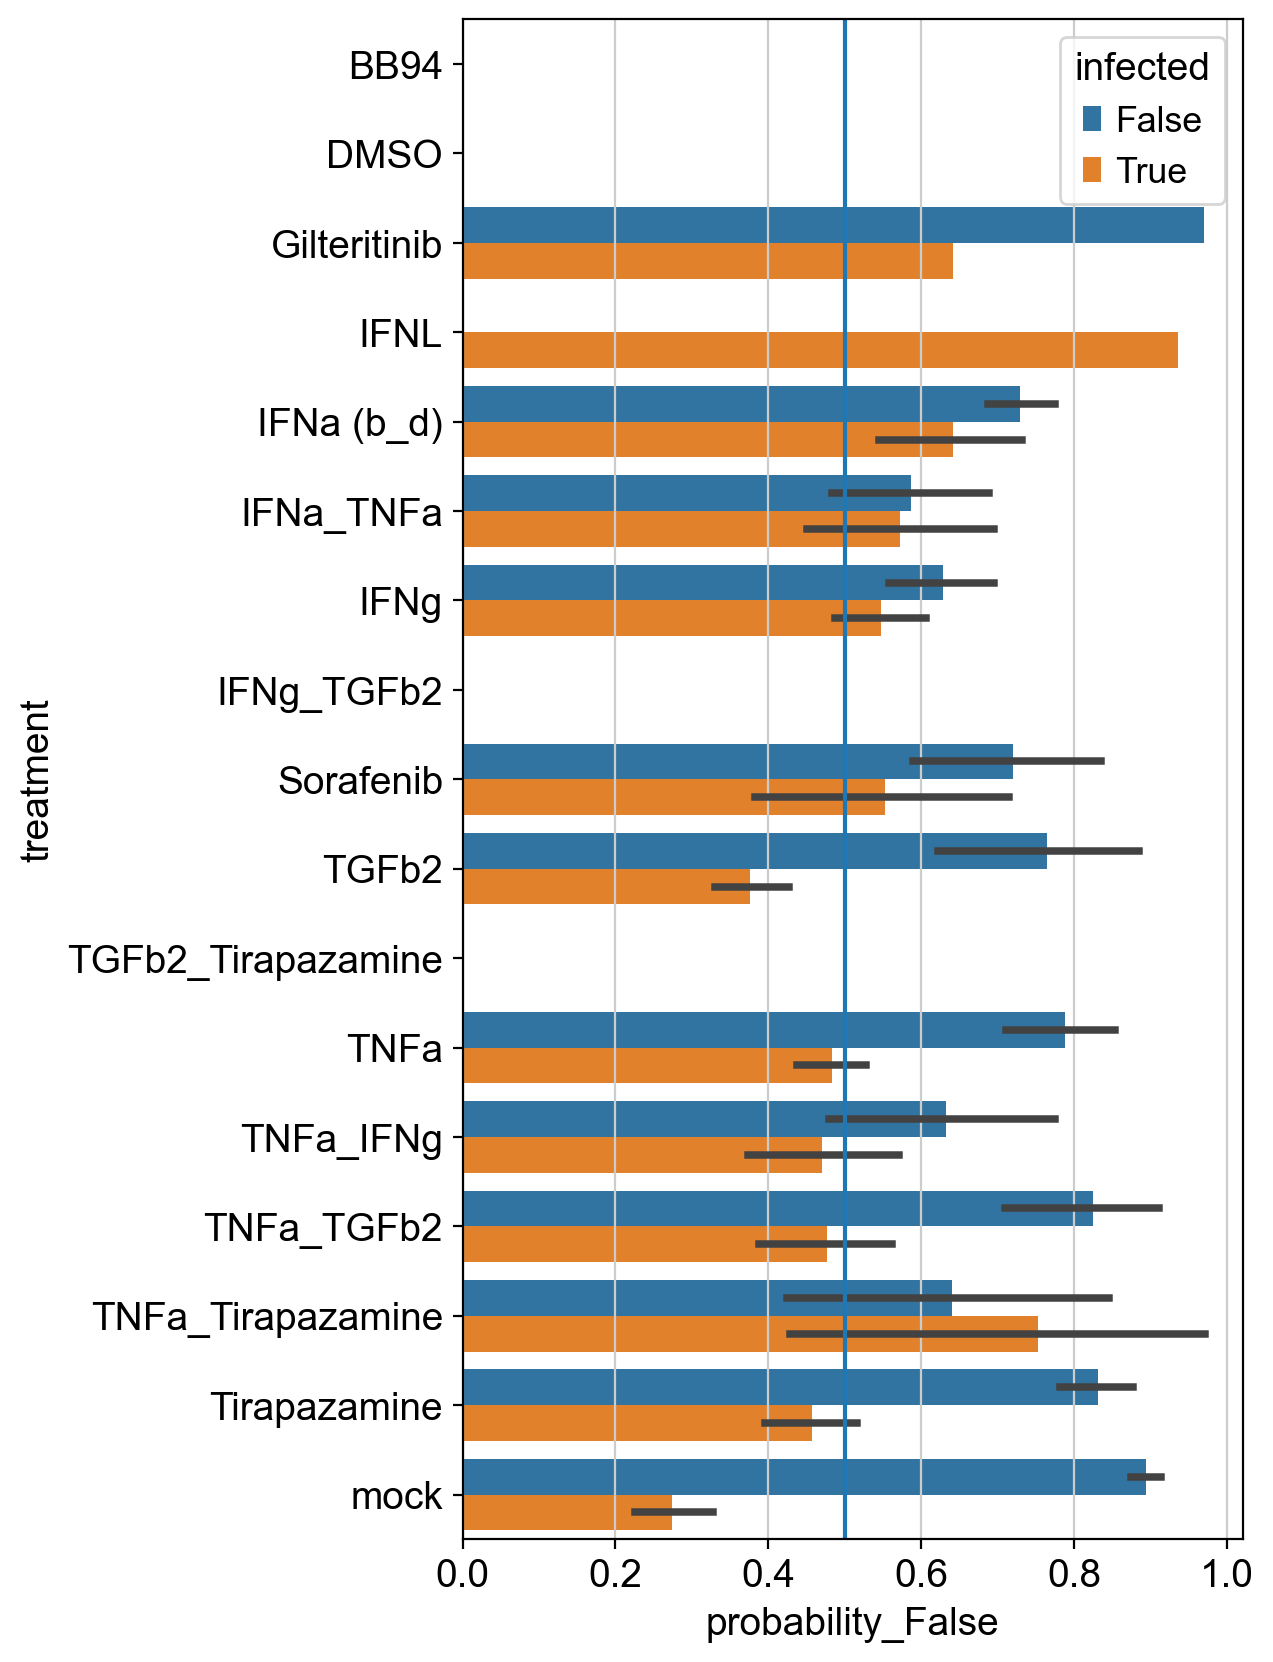

In [107]:
plt.figure(figsize=(5, 10))
sns.barplot(data=df[df.leiden == '20.1'], x='probability_False', y='treatment', hue='infected')
plt.axvline(.5)

Can we identify a bystander population?

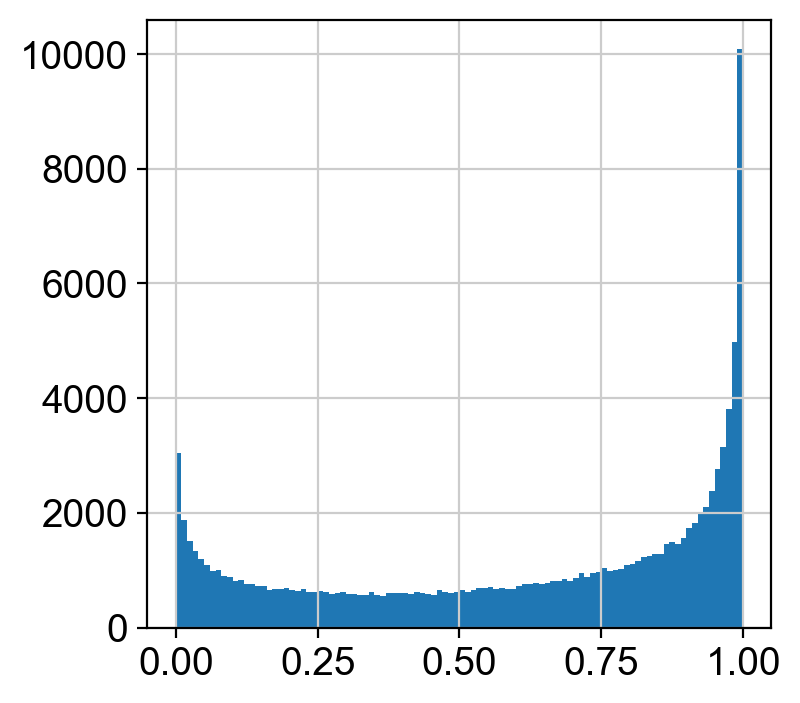

In [148]:
plt.hist(adata[adata.obs.infected == 'True'].obs.probability_True.values, bins=100);

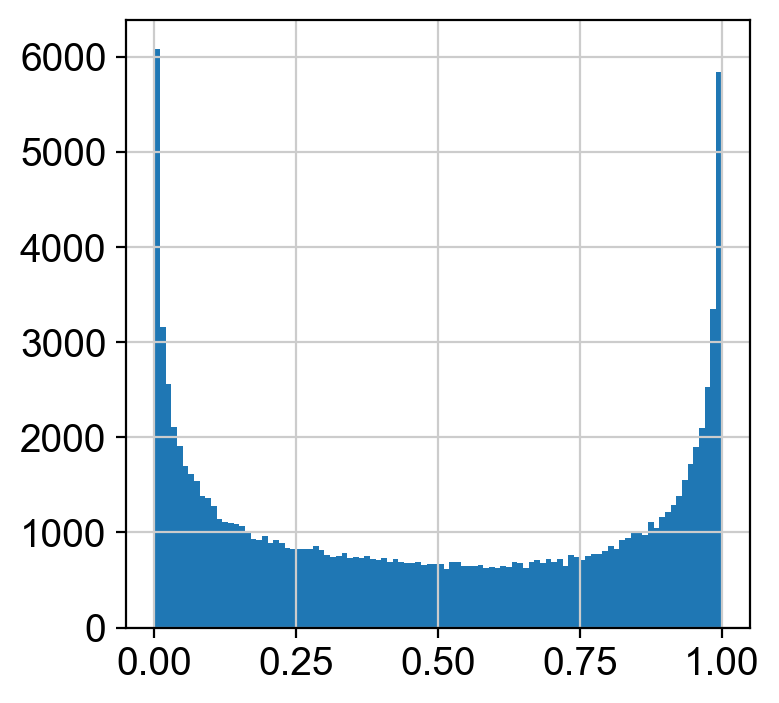

In [149]:
plt.hist(adata[adata.obs.infected == 'False'].obs.probability_True.values, bins=100);